# Bike Share Replenishment

## Introduction

Bike Share Toronto was designed to allow users to make short trips around town. The sturdy-framed bikes are available at any docking station in the city. The bikes can be taken from any station and returned to any station in the bike share system. 

According to the CBC, the project has required more than $ 27.5 million in public funds on service operations since 2014, and more funding is every time on the works. This has drawn several criticisms given the fact that the service is still not profitable for the city and has been **cash flow negative** and losing money for a few years now, according to CBC. Furthermore, several figures demonstrate that the service is not efficient using its resources, one big example of this is the fact that as of Nov. 2018, the service had more than 3.750 bikes for a 1.8 million ridership, a mere 480 rides per bike a year, a little over **one ride per day per bike**. This is even more worrisome today since the service offers 5.000 bikes according to their site, and rumors about service expansion have spread out. Also, and even more important it's been a proof of non-sustainable eco-friendly alternative transportation service. 

Moving 5.000 bikes around 465 stations throughout Toronto is a major engineering and planning challenge to tackle. Therefore, predicting where, when and how many bikes should be moved from a station to another using their own data would be a major help for their operations department. *This report presents a methodology for modeling the bike demand along with examples of how it could be used for prediction in this system*. It also analyzes more in depth high demand months (June, July and August) and approximates the amount of bikes to be moved using existing data.


## Data availability

Since **public historical information about station status is not available**, in order to perform this analysis, we rely on different sources of information to approximate the variables of interest.

1. Open data for 2017 ridership available [here](https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a1a0ee42-caf5-4395-abbc-58925c7434dd). This data was used to calculate the rate of change (explained below) for all stations.

2. Online data for stations general information available through an API [here](https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information). This was used to update the information from 2017 with information from today regarding station capacity, coordinates, location, name, ID, among others.

### Remarks
* Historic data for state of stations between 2011 and 2018 is available upon request [here](https://data.cdrc.ac.uk/dataset/toronto-bss), this application process is underway right now to further update the model and analysis.
* Real-time data for stations' status (including bikes parked and available spots) available [here](https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_status)


## Data Cleansing

This section explores the preprocessing steps that were carried out to clean the data and generate a dataset with relevant information for exploratory and predictive data analysis.

### Known data issues to tackle

- Datatime formats do not match accross the dataset.
- Station IDs inexistent for Q3 and Q4.
- Shifted columns in Q3 and Q4.
- Significant number of outliers to deal with.
- Some null values.


In [0]:
# Load all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
from google.colab import drive
from datetime import datetime

import requests
import seaborn as sns
import json
import os

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer

%pip install fuzzywuzzy[speedup]

from fuzzywuzzy import process
from fuzzywuzzy import fuzz

warnings.filterwarnings('ignore')

     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144666 sha256=ec5a399ec479fb3ce4bedb77b425d5dac5bca62837e5ebd24fe523cca986c226
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-levenshtein


First, let's load the data.

In [0]:
#Connect to drive folder
drive.mount('/content/gdrive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Read the data
bike_df = pd.read_csv('/content/gdrive/My Drive/1000ml/0_BikeShare/2017_Toronto_Bikeshare.csv')

In [0]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492370 entries, 0 to 1492369
Data columns (total 9 columns):
trip_id                  1492370 non-null object
trip_start_time          1492369 non-null object
trip_stop_time           1492369 non-null object
trip_duration_seconds    1492369 non-null float64
from_station_id          1492369 non-null object
from_station_name        1492368 non-null object
to_station_id            1492369 non-null object
to_station_name          465476 non-null object
user_type                465476 non-null object
dtypes: float64(1), object(8)
memory usage: 102.5+ MB


### Null Values

- The dataset contains 9 columns and 1.492.370 registers.
- Null values in Q3 and Q4 given shifted columns (see ``to_station_name`` and `user_type` )
- There are a couple of null values registers in the dataset.


In [0]:
#Get count of null registers
bike_df.isna().sum()

trip_id                        0
trip_start_time                1
trip_stop_time                 1
trip_duration_seconds          1
from_station_id                1
from_station_name              2
to_station_id                  1
to_station_name          1026894
user_type                1026894
dtype: int64

Let's take a look at the null values

In [0]:
bike_df[bike_df.from_station_name.isna()]

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
1424602,2302635,11/29/17 05:53:54,NULLNULL,0.0,Seaton St / Dundas St E,NaN,Casual,NaN,NaN
1492369,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This two rows do not have valuable information, hence, will be deleted

In [0]:
## Drop these two columns
bike_df.drop(index=bike_df[bike_df.from_station_name.isna()].index, inplace=True)

Now let's check the inconsistencies and null values for Q3 and Q4

In [0]:
bike_df[bike_df.to_station_name.isna()].head(2)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
465476,1253914,7/1/2017 0:00,7/1/2017 0:15,910.0,Princess St / Adelaide St E,424 Wellington St W,Member,NaN,NaN
465477,1253915,7/1/2017 0:01,7/1/2017 0:15,837.0,Fort York Blvd / Capreol Crt,HTO Park (Queens Quay W),Casual,NaN,NaN


Here, we can see that the columns are shifted to the left, causing null values in `to_station_name` and `user_type`, not to mention inconsistencies in all stations-related columns (names and IDs). We will have to fix that.

### Cleaning timestamps

After reviewing the dataset, we could observe that datetimes columns for each quarter were parsed differently with the following formats

```
date_formats = {
    '2017 Q1': ['%d/%m/%Y %H:%M', -4],
    '2017 Q2': ['%d/%m/%Y %H:%M', -4],
    '2017 Q3': ['%m/%d/%Y %H:%M', 0],  *
    '2017 Q4': ['%m/%d/%y %H:%M:%S', 0], *
}

```

`*` These also have some string issues to be dealt with. First thing we do, is divide the dataset in two parts for proper preprocessing.


In [0]:
#Split the data into two semesters for date correction
bike_df1 = bike_df.loc[:465475,:]
bike_df2 = bike_df.loc[465476:,:]

Then, a couple of functions are created to properly handle each of the subsets with the aforementioned information.

In [0]:
def format_date_S1(date):
  """Function for cleaning datetimes according to detected format for the first semester subset:
  
  Takes a date with format ['%d/%m/%Y %H:%M', -4] and returns a datetime object.
  
  """
  formatted = datetime.strptime(date, '%d/%m/%Y %H:%M')
  return formatted  

def format_date_S2(date):
  """Function for cleaning the second semester subset, which is known to have switched string issues
  along with two different formats for each Q, as stated before.
  
  Takes a date with any of the formats ['%m/%d/%Y %H:%M', 0] or ['%m/%d/%y %H:%M:%S', 0] and returns
  a d datetime object.
  
  """  
  
  # Check for years detected within the dataset that are not desired.
  not_wanted = ('2001', '2010', '2011', '2012')
  
  #Check if formatting is standard and belongs to the group of interest for applying pd.to_datetime function
  if not date.startswith(not_wanted):
    formatted = pd.to_datetime(date).to_pydatetime()
        
  else:
      #Check first type of formatting
    try:
      formatted = datetime.strptime(date[2:], '%m/%d/%y %H:%M:%S')
    except ValueError:
      #Check second type of formatting
      formatted = datetime.strptime(date[2:], '%m-%d-%y %H:%M')
  
  return formatted

Now we will vectorize both functions in order to apply it efficiently along the timestamp columns.

In [0]:
format_date_S1v = np.vectorize(format_date_S1)
format_date_S2v = np.vectorize(format_date_S2)

Apply timestamp transformation for the first semester subset using the appropriate function

In [0]:
#Apply to two date columns
bike_df1['trip_start_time_f'] = format_date_S1v(bike_df1.trip_start_time)
bike_df1['trip_stop_time_f'] = format_date_S1v(bike_df1.trip_stop_time)

This part runs pretty quick given the fact that datetime processing only requires string-to-date parsing. Now let's apply date formatting for the second semester subset with the other function

In [0]:
#Apply to two date columns
bike_df2['trip_start_time_f'] = format_date_S2v(bike_df2.trip_start_time)
bike_df2['trip_stop_time_f'] = format_date_S2v(bike_df2.trip_stop_time)

Since this function uses `pd.to_datetime` on some dates it is indeed slower to apply, one could further optimize this function by modifying that line of code and implementing string-to-date parsing, this will improve scalability for large datasets.

Now let's check if we have the years we want with the following test:

In [0]:
# Year should only be 2017 for the first semester (since we are only dealing with data from 2017)
[set([date.year for date in bike_df1.trip_start_time_f]), set([date.year for date in bike_df1.trip_stop_time_f])]

[{2017}, {2017}]

In [0]:
# Year should be 2017 and 2018 for the second semester given the fact that some trips finish in 2018
[set([date.year for date in bike_df2.trip_start_time_f]), set([date.year for date in bike_df2.trip_stop_time_f])]

[{2017}, {2017, 2018}]

**Time continuiity**

Create a temporary column to verify the difference between one ``trip_start_time_f`` and the previous one. The difference shouldn't be negative for a sorted dataframe and shouldn't be more than 1 day (for trips that start one day and finish the following day).

In [0]:
# Concatenate both dataframes
bike_df = pd.concat([bike_df1, bike_df2])

#Create desired column using the formatted start time
bike_df['temp_start_diff'] = bike_df.trip_start_time_f.dt.dayofyear.diff()

#Check for values different than zero or one
non_cont = bike_df.loc[(bike_df.temp_start_diff < 0) | (bike_df.temp_start_diff >1), :]

#Get those non continuous registers
non_cont.shape[0]

16

Here, we can see that we are in possession of 16 registers with an odd behavior in which the continuity is not preserved. Let's check one of those out.

In [0]:
#Get non continuous trip, previous and following
idx = non_cont.index[0]
bike_df.loc[idx-1:idx+1,:]

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,trip_start_time_f,trip_stop_time_f,temp_start_diff
156831,896854,12/4/2017 0:29,12/4/2017 0:35,374.0,7001,Lower Jarvis St / The Esplanade,7060,Princess St / Adelaide St,Member,2017-04-12 00:29:00,2017-04-12 00:35:00,0.0
156832,896859,11/4/2017 23:52,11/4/2017 23:57,271.0,7029,Bay St / Bloor St W,7025,Ted Rogers Way / Bloor St E,Member,2017-04-11 23:52:00,2017-04-11 23:57:00,-1.0
156833,896860,12/4/2017 0:21,12/4/2017 0:36,909.0,7029,Bay St / Bloor St W,7076,York St / Queens Quay W,Member,2017-04-12 00:21:00,2017-04-12 00:36:00,1.0


After reviewing, it's not clear why these rows are flagged, one hypothesis could be a timezone issue on storage. We may calculate some statistics to check if those registers are outliers or present significant differences in relevant statistics compared to the whole dataframe.

In [0]:
pd.DataFrame([bike_df.trip_duration_seconds.describe().round(0), 
              non_cont.trip_duration_seconds.describe().round(0)],
            index=['full', 'non_cont'])

,count,mean,std,min,25%,50%,75%,max
full,1492368.0,1018.0,9773.0,1.0,415.0,654.0,1020.0,6382030.0
non_cont,16.0,620.0,417.0,60.0,414.0,490.0,706.0,1611.0


Other than the standard deviation, there are no significant differences overall, this is specially visible in the median. The mean and standard deviation are expected to vary significantly given the presence of outliers in full dataset (read below). Given this, we will include this registers and reorder the dataframe by `trip_start_date_f`,

In [0]:
#Sort dataframe by date
bike_df.sort_values(by='trip_start_time_f', inplace=True)

Now that we have our dates properly formatted, let's drop `temp_start_diff`, `temp_start_diff` and `trip_stop_time`

In [0]:
bike_df.drop(columns=['trip_start_time', 'trip_stop_time', 'temp_start_diff'], inplace=True)

With our dates meeting the standards, we can move on and continue working with null values, but first, let's save this dataframe to avoid running these lines every time we need.

In [0]:
bike_df.to_csv('/content/gdrive/My Drive/1000ml/2_BikeShareReplenishment/2017_Toronto_Bikeshare_Dates.csv',
              header=True, index=False)

### Correcting Stations Data

We will connect to the Toronto Bike Share API to gather the stations data, in order to standardize and fix issues related to stations' in our dataframe.

In [0]:
#Import the stored data
bike_df = pd.read_csv('/content/gdrive/My Drive/1000ml/2_BikeShareReplenishment/2017_Toronto_Bikeshare_Dates.csv',
                        parse_dates=['trip_start_time_f', 'trip_stop_time_f'])

bike_df.head(2)

,trip_id,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,trip_start_time_f,trip_stop_time_f
0,712382,223.0,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member,2017-01-01,2017-01-01 00:03:00
1,712383,279.0,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member,2017-01-01,2017-01-01 00:05:00


As seen, dates are already parsed correctly by the pandas package. First, we are going to use the information from the `station_information` endpoint to fix the stations data.

In [0]:
#Send get request
req = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')

Now get the stations data from the whole json object

In [0]:
#Extract the data
stations_data = pd.DataFrame(json.loads(req.content)['data']['stations'])[['station_id', 'name', 'capacity', 'lat', 'lon']]

#Remove whitespaces
stations_data.name = stations_data.name.str.strip()
stations_data.head(1)

,station_id,name,capacity,lat,lon
0,7000,Fort York Blvd / Capreol Ct,31,43.639832,-79.395954


When was the last update?

In [0]:
datetime.fromtimestamp(json.loads(req.content)['last_updated'])

datetime.datetime(2019, 10, 8, 14, 4, 15)

So this information is up to date (but in a different timezone). However, we must check if the number of stations changed since 2017.

In [0]:
#Stations as of today
stations_data.name.shape

(458,)

For the record, this differs a bit from the information displayed on the website stating that 465 stations are available. Now let's shift the columns for the second semester in order to have the complete information about stations.

In [0]:
#Shift the columns to the right place
flags = bike_df.to_station_name.isna()
bike_df.loc[flags, 'user_type'] = bike_df.loc[flags, 'to_station_id']
bike_df.loc[flags, 'to_station_name'] = bike_df.loc[flags, 'from_station_name']
bike_df.loc[flags, 'from_station_name'] = bike_df.loc[flags, 'from_station_id']

#Now set all the unknown IDs to None to make them easy to detect
bike_df.loc[flags, 'to_station_id'] = None
bike_df.loc[flags, 'from_station_id'] = None

Now let's take a look at the resulting dataframe to see if it's what we expected.

In [0]:
bike_df.tail(2)

,trip_id,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,trip_start_time_f,trip_stop_time_f
1492366,2383645,26.0,None,Phoebe St / Spadina Ave,None,Phoebe St / Spadina Ave,Member,2017-12-31 23:49:08,2017-12-31 23:49:34
1492367,2383646,480.0,None,Phoebe St / Spadina Ave,None,Simcoe St / Queen St W,Member,2017-12-31 23:49:41,2017-12-31 23:57:41


Great, everything is in the right place and the station ID columns are now none. Now let's get the full list of stations used in 2017.

In [0]:
#Get the origin stations and IDs
start = bike_df[['from_station_id', 'from_station_name']]
start.columns = ['id', 'station']

#Get the destination stations and IDs
stop = bike_df[['to_station_id', 'to_station_name']]
stop.columns = ['id', 'station']

#Now let's merge those together to obtain names for stations in 2017
stations_2017 = pd.concat([start, stop]).drop_duplicates(['station']).sort_values(by='station').reset_index(drop=True)
stations_2017.station = stations_2017.station.str.strip()

In [0]:
#Inspect
stations_2017.head()

,id,station
0,None,111 Bond St (North of Dundas St E) - SMART
1,7071,161 Bleecker St (South of Wellesley)
2,7070,25 York St (ACC/Union Station South)
3,None,424 Wellington St W
4,7123,424 Wellington St. W


In [0]:
stations_2017.shape

(293, 2)

We have a total of 293 "unique" stations, however, we can see in the last step that some of these stations are repeated with a slightly different name. First we are going to check the rows that can be directly mapped to today's stations.

For this mapping we will use three approaches:

1. Will be only by full string matching the station name (``strmatch``) to the name in ``stations_data``
2. we will use **fuzzywuzy**, a string matching package to perform partial string matching of similar names and import the fields from our ``stations_data``.
3. Those stations that are left will be filled with None variables for future analysis.


In [0]:
def fix_null_station(station, choices):
  """This function will fix null stations by applying fuzzywuzy to the string and
  filtering those that do not meet a threshold of 80 or more according to wuzy partial
  ratio matching algorithm.
  
  Takes a station and a set of choices (which is the list of current stations) and 
  matches the string with the greatest score if it meets the criteria. It will return a 
  dictionary with the name, the index and the score of the station (if found).
  
  """
  
  #Create empty dictionary for storing station information
  stat_dict = {}
  new_score = None

  # Get the best match using fuzzywuzy
  best_match = process.extract(station, choices.name, limit=1, scorer=fuzz.partial_ratio)[0]

  # Check if match score above threshold and assign values accordingly
  if best_match[1] > 80:
    new_idx = best_match[2]
    new_station = best_match[0]
    new_score = best_match[1]
  else:
    new_idx = None
    new_station = station
    
  #Add data to dictionary and append to list
  stat_dict['idx'] = new_idx
  stat_dict['name'] = new_station
  stat_dict['score'] = new_score
      
  return(stat_dict)

Now let's preprocess the `stations_2017` dataframe to get the data from the stations matche through either of the two methods (string matching or `fix_null_values`) and non-matched.

In [0]:
stations_list = []

for row in stations_2017.itertuples():
  
  #Create a dictionary of station
  stat_dict = {}
  
  #Find the register through string matching only
  stat_data = stations_data.loc[stations_data.name == row[2],:].get_values()
  
  if stat_data.shape[0] > 0:
    
    #Assign to dictionary if found
    stat_dict['idx'] = stat_data[0][0]
    stat_dict['name'] = stat_data[0][1]
    stat_dict['capacity'] = stat_data[0][2]
    stat_dict['lat'] = stat_data[0][3]
    stat_dict['lon'] = stat_data[0][4]
    stat_dict['matched'] = 'strmatch'
    stat_dict['score'] = 100
    
  else:
    
    #Set values using fuzzywuzy
    best_result = fix_null_station(row[2], stations_data)
    
    #Set value according to station found
    stat_data = stations_data.loc[stations_data.name == best_result['name'],:].get_values()
      
    if stat_data.shape[0] > 0:
      
      #Set values if exists    
      stat_dict['idx'] = stat_data[0][0]
      stat_dict['name'] = stat_data[0][1] #Hey
      stat_dict['capacity'] = stat_data[0][2]
      stat_dict['lat'] = stat_data[0][3]
      stat_dict['lon'] = stat_data[0][4]
      stat_dict['matched'] = 'fuzzywuzy'
      stat_dict['score'] = best_result['score']
    
    else:
      
      #We couldn't find it 
      stat_dict['idx'] = None
      stat_dict['name'] = row[2]   #Set original date
      stat_dict['capacity'] = None
      stat_dict['lat'] = None
      stat_dict['lon'] = None
      stat_dict['matched'] = 'No'
      stat_dict['score'] = None
  
  # Append to list of dictionaries
  stations_list.append(stat_dict)

In [0]:
len(stations_list)

293

Now we have a list of dictionaries with all the information about each of the 293 stations extracted from the dataframe, namely ID, name, capacity, latitude, longitude, if it was matched or not, and the score of the match if fuzzywuzy was used. Now let's turn it into a dataframe to get a full list of stations for the ridership data.

In [0]:
#Create the dataset as needed
stations_df = pd.DataFrame(stations_list)
stations_df.columns =['cap', 'st_id', 'lat', 'lon', 'matched', 'st_name', 'score']
stations_df.head(5)

,cap,st_id,lat,lon,matched,st_name,score
0,16.0,7268,43.656927,-79.378497,strmatch,111 Bond St (North of Dundas St E) - SMART,100.0
1,23.0,7071,43.666233,-79.373327,strmatch,161 Bleecker St (South of Wellesley),100.0
2,26.0,7033,43.645609,-79.380386,fuzzywuzy,Union Station,100.0
3,15.0,7123,43.643834,-79.396649,strmatch,424 Wellington St W,100.0
4,15.0,7123,43.643834,-79.396649,fuzzywuzy,424 Wellington St W,95.0


Now we are going to use this information to match the capacity, ID, lat, long and name variables to our ``stations_2017`` dataset to complete the information in it.

In [0]:
#Merge dataframes
stations_df = stations_2017.reset_index(drop=True).merge(stations_df.reset_index(drop=True), 
                                                         left_index=True, 
                                                         right_index=True)
#Display a bit
stations_df.head(2)

,id,station,cap,st_id,lat,lon,matched,st_name,score
0,None,111 Bond St (North of Dundas St E) - SMART,16.0,7268,43.656927,-79.378497,strmatch,111 Bond St (North of Dundas St E) - SMART,100.0
1,7071,161 Bleecker St (South of Wellesley),23.0,7071,43.666233,-79.373327,strmatch,161 Bleecker St (South of Wellesley),100.0


Now let's check if we have some inconsistencies in the mapping carried out.

In [0]:
#Check for null values
stations_df.loc[pd.isna(stations_df.st_id), :].reset_index(drop=True)

,id,station,cap,st_id,lat,lon,matched,st_name,score
0,7179,Bloor GO / UP Station/ Rail Path,NaN,None,NaN,NaN,No,Bloor GO / UP Station/ Rail Path,NaN
1,7061,Bloor St / Brunswick Ave,NaN,None,NaN,NaN,No,Bloor St / Brunswick Ave,NaN
2,7073,Bremner Blvd / Spadina Ave,NaN,None,NaN,NaN,No,Bremner Blvd / Spadina Ave,NaN
3,7130,Davenport Rd / Bedford Rd,NaN,None,NaN,NaN,No,Davenport Rd / Bedford Rd,NaN
4,None,Fringe Next Stage - 7219,NaN,None,NaN,NaN,No,Fringe Next Stage - 7219,NaN
5,None,Margueretta St / College St,NaN,None,NaN,NaN,No,Margueretta St / College St,NaN
6,7183,Margueretta St / College St W,NaN,None,NaN,NaN,No,Margueretta St / College St W,NaN
7,None,Michael Sweet Ave / St. Patrick St,NaN,None,NaN,NaN,No,Michael Sweet Ave / St. Patrick St,NaN
8,7171,Ontario Place Blvd / Remembrance Dr,NaN,None,NaN,NaN,No,Ontario Place Blvd / Remembrance Dr,NaN
9,None,Roxton Rd / College St,NaN,None,NaN,NaN,No,Roxton Rd / College St,NaN


So, aftwer reviewing manually these registers, it turns out that most of these 13 stations no longer exist (according to BTS data), the only two stations that were found and not matched by our algorithm were:

- 'Temperance St / Yonge St	' -> 'Temperance St. Station'
- 'Bloor GO / UP Station/ Rail Path	' -> 'Bloor GO / UP Station (West Toronto Railpath)'

To improve the score in these two, we will modify the `stations_df` data to replace these names in order to match for both of these stations to the map below. We are offering a little bit of help to the string matching algorithm.

In [0]:
#Stations to be replaced
str_dict = {'Temperance St / Yonge St': 'Temperance St. Station',
            'Bloor GO / UP Station/ Rail Path	': 'Bloor GO / UP Station (West Toronto Railpath)'}

# Find these stations and modify the stations_df map.
for key, value in str_dict.items():
  
  #Get index
  idx = stations_df.index[stations_df.station == key.strip()]
  value = value.strip()
  
  #Fill values manually
  stations_df.loc[idx, 'st_id'] = stations_data.station_id[stations_data.name == value].values[0]
  stations_df.loc[idx, 'st_name'] = stations_data.name[stations_data.name == value].values[0]
  stations_df.loc[idx, 'cap'] = stations_data.capacity[stations_data.name == value].values[0]
  stations_df.loc[idx, 'lat'] = stations_data.lat[stations_data.name == value].values[0]
  stations_df.loc[idx, 'lon'] = stations_data.lon[stations_data.name == value].values[0]
  stations_df.loc[idx, 'matched'] = 'No'
  stations_df.loc[idx, 'score'] = None

Check if it was corrected and we have two registers less in our dataframe.

In [0]:
stations_df.loc[pd.isna(stations_df.st_id), :].reset_index()

,index,id,station,cap,st_id,lat,lon,matched,st_name,score
0,32,7061,Bloor St / Brunswick Ave,NaN,None,NaN,NaN,No,Bloor St / Brunswick Ave,NaN
1,44,7073,Bremner Blvd / Spadina Ave,NaN,None,NaN,NaN,No,Bremner Blvd / Spadina Ave,NaN
2,83,7130,Davenport Rd / Bedford Rd,NaN,None,NaN,NaN,No,Davenport Rd / Bedford Rd,NaN
3,111,None,Fringe Next Stage - 7219,NaN,None,NaN,NaN,No,Fringe Next Stage - 7219,NaN
4,166,None,Margueretta St / College St,NaN,None,NaN,NaN,No,Margueretta St / College St,NaN
5,167,7183,Margueretta St / College St W,NaN,None,NaN,NaN,No,Margueretta St / College St W,NaN
6,173,None,Michael Sweet Ave / St. Patrick St,NaN,None,NaN,NaN,No,Michael Sweet Ave / St. Patrick St,NaN
7,180,7171,Ontario Place Blvd / Remembrance Dr,NaN,None,NaN,NaN,No,Ontario Place Blvd / Remembrance Dr,NaN
8,222,None,Roxton Rd / College St,NaN,None,NaN,NaN,No,Roxton Rd / College St,NaN
9,244,7084,Stephenson Ave / Main St,NaN,None,NaN,NaN,No,Stephenson Ave / Main St,NaN


Great, the two stations that we needed information from are now correct. Now it's time to map the values to the stations, for this we will extract a subset of `stations_df` because not all the information is needed.

In [0]:
#Create the map to use
stations_map = stations_df[['station', 'st_id', 'st_name', 'lat', 'lon', 'cap']]
stations_map.station = stations_map.station.str.strip()
stations_map.head()

,station,st_id,st_name,lat,lon,cap
0,111 Bond St (North of Dundas St E) - SMART,7268,111 Bond St (North of Dundas St E) - SMART,43.656927,-79.378497,16.0
1,161 Bleecker St (South of Wellesley),7071,161 Bleecker St (South of Wellesley),43.666233,-79.373327,23.0
2,25 York St (ACC/Union Station South),7033,Union Station,43.645609,-79.380386,26.0
3,424 Wellington St W,7123,424 Wellington St W,43.643834,-79.396649,15.0
4,424 Wellington St. W,7123,424 Wellington St W,43.643834,-79.396649,15.0


Now, before we finally assign the new data to the ``bike_df`` main dataframe we are going to need a bit of preprocessing

In [0]:
bike_df.from_station_name = bike_df.from_station_name.str.strip()
bike_df.to_station_name = bike_df.to_station_name.str.strip()

Now merge the ``stations_map`` with our main dataframe to correct the origin and destination information and attached extra data.

In [0]:
bike_clean = bike_df.merge(stations_map,
                      how='left', 
                      left_on='from_station_name', 
                      right_on='station')\
                  .merge(stations_map, 
                      how='left', 
                      left_on='to_station_name', 
                      right_on='station', suffixes = ('_orig','_dest'))

Now let's see if there were any stations left to match for the origin and destination stations.

In [0]:
bike_clean.from_station_name[pd.isna(bike_clean.st_id_orig)].nunique()

11

In [0]:
bike_clean.to_station_name[pd.isna(bike_clean.st_id_dest)].nunique()

11

This is expected since we saw before that we did not have any data for 11 stations (which are represented here). That is to say, the only null values that we have for non-matched stations are the ones we already know no longer exist. Now let's drop some unusefull columns from this wide dataset

In [0]:
bike_clean.head(1)

,trip_id,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,trip_start_time_f,trip_stop_time_f,station_orig,st_id_orig,st_name_orig,lat_orig,lon_orig,cap_orig,station_dest,st_id_dest,st_name_dest,lat_dest,lon_dest,cap_dest
0,712382,223.0,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member,2017-01-01,2017-01-01 00:03:00,Wellesley St E / Yonge St Green P,7051,Wellesley St E / Yonge St (Green P),43.66506,-79.38357,17.0,Church St / Wood St,7089,Church St / Wood St,43.662712,-79.379903,19.0


In [0]:
bike_clean.drop(columns=['station_orig', 'station_dest', 'from_station_id', 
                         'to_station_id', 'from_station_name', 'to_station_name'], inplace=True)

Now let's drop the trips with **unknown origin and destination** stations since those are not useful for our analysis

In [0]:
#How many of those registers we have?
bike_clean.index[pd.isna(bike_clean.st_id_orig) &  pd.isna(bike_clean.st_id_dest)].nunique()

6606

In [0]:
#Drop
bike_clean.drop(index=bike_clean.index[pd.isna(bike_clean.st_id_orig) &  pd.isna(bike_clean.st_id_dest)], inplace=True)

**Partial station data**

We also have some data in which one of the two stations is unknown. We will perform some Exploratory Data Analysis on it to assess whether if we could omit it or not.

In [0]:
#Get the partial records
partial_records = bike_clean[pd.isna(bike_clean.st_id_orig) | pd.isna(bike_clean.st_id_dest)]

How are these partial records distributed during the year?

Text(0.5, 0, 'Months')

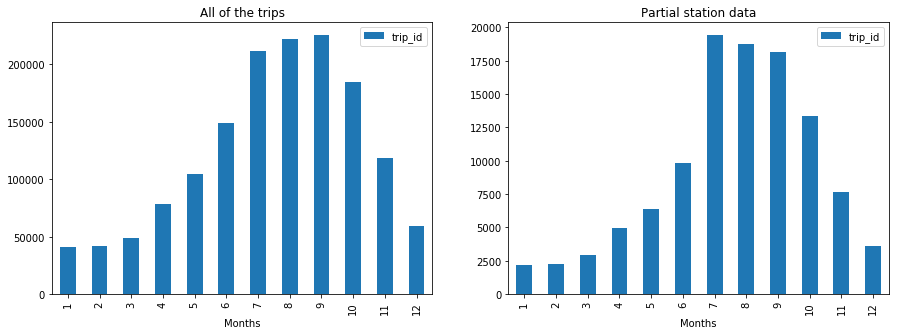

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Firtst plot the distribution of trips during the whole year
bike_clean.groupby(bike_clean.trip_start_time_f.dt.month).aggregate({'trip_id': 'count'}).plot(kind='bar', ax=ax[0])
ax[0].set_title('All of the trips')
ax[0].set_xlabel('Months')
partial_records.groupby(partial_records.trip_start_time_f.dt.month).aggregate({'trip_id': 'count'}).plot(kind='bar', ax=ax[1])
ax[1].set_title('Partial station data')
ax[1].set_xlabel('Months')

Here, we can see that these are pretty much distributed similarly to the full data throughout the year, hence it will have a distributed impact on the analysis. 

However, even though the ``None`` stations no longer exist, and under the assumption that **people using the related start stations would still take the service to go to another nearby**, and **people arriving to the related stop destinations would still get there from any other destination**, we would not delete this data and use it for the analysis.

But first, store this copy

In [0]:
bike_clean.to_csv('/content/gdrive/My Drive/1000ml/2_BikeShareReplenishment/2017_Toronto_Bikeshare_Stations.csv',
              header=True, index=False)

### Verifying trip duration

Since we already have a tidy dataset, it's worth the time verifying the ``trip_duration_seconds`` variable using our timestamps

In [0]:
#Import the data
bike_df = pd.read_csv('/content/gdrive/My Drive/1000ml/2_BikeShareReplenishment/2017_Toronto_Bikeshare_Stations.csv',
                        parse_dates=['trip_start_time_f', 'trip_stop_time_f'])

bike_df.head(2)

,trip_id,trip_duration_seconds,user_type,trip_start_time_f,trip_stop_time_f,st_id_orig,st_name_orig,lat_orig,lon_orig,cap_orig,st_id_dest,st_name_dest,lat_dest,lon_dest,cap_dest
0,712382,223.0,Member,2017-01-01,2017-01-01 00:03:00,7051.0,Wellesley St E / Yonge St (Green P),43.665060,-79.383570,17.0,7089.0,Church St / Wood St,43.662712,-79.379903,19.0
1,712383,279.0,Member,2017-01-01,2017-01-01 00:05:00,7143.0,Kendal Ave / Bernard Ave,43.671513,-79.408317,15.0,7154.0,Bathurst Subway Station,43.666667,-79.411667,23.0


We will create a new column to calculate the difference between the stop time and the start time, namely ``trip_stop_time_f`` and ``trip_start_time_f``

In [0]:
#Calculate the duration
bike_df['trip_duration'] = bike_df.trip_stop_time_f - bike_df.trip_start_time_f
#Convert it to seconds
bike_df['trip_duration'] = bike_df.trip_duration.dt.seconds

Let's look at some statistics for these numbers

In [0]:
pd.DataFrame([bike_df.trip_duration.divide(60).describe().round(1), bike_df.trip_duration_seconds.divide(60).describe().round(1)])

,count,mean,std,min,25%,50%,75%,max
trip_duration,1485762.0,16.2,33.8,0.0,7.0,11.0,17.0,1439.0
trip_duration_seconds,1485762.0,16.9,163.2,0.0,6.9,10.9,17.0,106367.2


We can see that the calculated information from `trip_duration` looks **more reliable**, we have less variance and less extreme outliers, hence, we will use this information instead of the `trip_duration_seconds` variable given in the dataset. Now we will drop the variable from the dataset

In [0]:
#Drop trip_duration_seconds
bike_df.drop(columns='trip_duration_seconds', inplace=True)

In [0]:
#Get the null values finally
bike_df.isna().sum()

trip_id                  0
user_type                0
trip_start_time_f        0
trip_stop_time_f         0
st_id_orig           53969
st_name_orig             0
lat_orig             53969
lon_orig             53969
cap_orig             53969
st_id_dest           55449
st_name_dest             0
lat_dest             55449
lon_dest             55449
cap_dest             55449
trip_duration            0
dtype: int64

These null values are the unknown start/stop stations in which its pair is known and as discussed this will be used during the analysis. Now we got ourselves a clean dataset to analyze. Let's store a copy

In [0]:
bike_clean.to_csv('/content/gdrive/My Drive/1000ml/2_BikeShareReplenishment/2017_Toronto_Bikeshare_Duration.csv',
              header=True, index=False)

### Outliers detection

Let's begin with the `trip_duration` variable which seems to have some outliers given the previous statistics explored


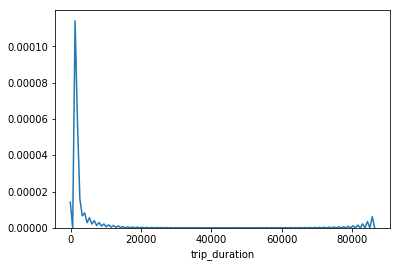

In [0]:
sns.distplot(bike_df.trip_duration, hist=False)

**Toronto Parking Authority (TPA)** generally considers trips less than a minute to be *false trips* in their own analysis, hence we are going to remove these from our data.

In [0]:
#Calculate the percentage of false trips
bike_df[bike_df.trip_duration < 60].shape[0]/bike_df.shape[0]

0.012242202990788565

This is about 1.2% of the data to be deleted.


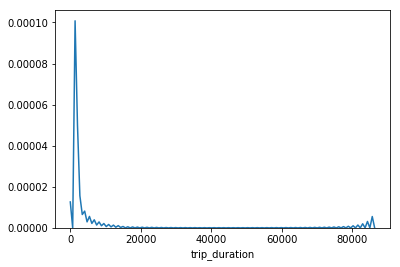

In [0]:
#Drop the false trips
bike_df = bike_df[bike_df.trip_duration > 60]

#Now plot the new distribution
sns.distplot(bike_df.trip_duration, hist=False)

We can still evidence some righ-tail outlers for this variable.

**Detecting outliers**

The outliers are defined as data points that are $±1.5 IQR$ (Inter Quartile Range) away from the median. Some of the outliers could be removed using this criteria.

In [0]:
# Get 25th and 7hth quarntile
q1 = bike_df.trip_duration.quantile(0.25)
q3 = bike_df.trip_duration.quantile(0.75)

# Calculate IQR
IQR = q3 - q1

#Get the percentage of data within this category
bike_df[((bike_df.trip_duration < (q1 - 1.5 * IQR)) | \
                                     (bike_df.trip_duration > (q3 + 1.5 * IQR)))] \
.reset_index(drop=True).shape[0]/bike_df.shape[0]

0.05580510737150375

According to this criteria, outliers represent about 5.6% of the dataset. This data will be ommited since we are interested in modeling an 'usual' service of the system.

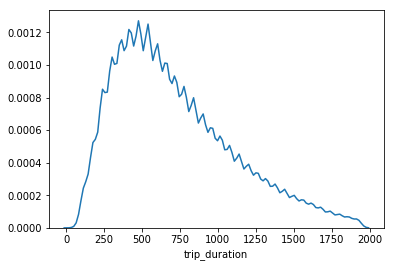

In [0]:
#Filter outliers out
bike_df = bike_df[~((bike_df.trip_duration < (q1 - 1.5 * IQR)) | \
                    (bike_df.trip_duration > (q3 + 1.5 * IQR)))].reset_index(drop=True)

#Plot new distribution
sns.distplot(bike_df.trip_duration, hist=False)

Beautiful, now let's store our clean dataset for further EDA.

In [0]:
bike_df.to_csv('/content/gdrive/My Drive/1000ml/2_BikeShareReplenishment/2017_Toronto_Bikeshare_Clean.csv',
              header=True, index=False)

## Narowing down the problem

In order to narrow down the analysis to prove modeling approaches, we will start analyzing popular start and stop stations and how these two numbers match.

In [0]:
#Import the data
bike_data = pd.read_csv('/content/gdrive/My Drive/1000ml/2_BikeShareReplenishment/2017_Toronto_Bikeshare_Clean.csv',
                        parse_dates=['trip_start_time_f', 'trip_stop_time_f'])

In [0]:
#Top 5 start stations (origin)
pd.DataFrame({'start_counts':bike_data.st_name_orig.value_counts(),
              'stop_counts': bike_data.st_name_dest.value_counts(),
             'start_pct': bike_data.st_name_orig.value_counts()/sum(bike_data.st_name_orig.value_counts())*100,
             'stop_pct': bike_data.st_name_dest.value_counts()/sum(bike_data.st_name_dest.value_counts())*100})\
.sort_values(by='start_counts', ascending=False).head(5).round(2)

,start_counts,stop_counts,start_pct,stop_pct
Union Station,27760,35600,2.02,2.59
Simcoe St / Wellington St South,20197,21614,1.47,1.58
Dundas St W / Yonge St,18205,19755,1.33,1.44
Bay St / Wellesley St W,17461,11275,1.27,0.82
King St W / Spadina Ave,16940,18431,1.23,1.34


In [0]:
#Top 5 stop stations (destination)
pd.DataFrame({'start_counts':bike_data.st_name_orig.value_counts(),
              'stop_counts': bike_data.st_name_dest.value_counts(),
             'start_pct': bike_data.st_name_orig.value_counts()/sum(bike_data.st_name_orig.value_counts())*100,
             'stop_pct': bike_data.st_name_dest.value_counts()/sum(bike_data.st_name_dest.value_counts())*100})\
.sort_values(by='stop_counts', ascending=False).head(5).round(2)

,start_counts,stop_counts,start_pct,stop_pct
Union Station,27760,35600,2.02,2.59
Simcoe St / Wellington St South,20197,21614,1.47,1.58
Dundas St W / Yonge St,18205,19755,1.33,1.44
Princess St / Adelaide St E,15903,18823,1.16,1.37
King St W / Spadina Ave,16940,18431,1.23,1.34


For the start and stop stations, the top 10 stations of 266 (3.6%) account for the 13% and 14% of all trips, respectively. To create a first model, we will only analyze supply and demand for the top station, which is Union Station, accounting for a 2.6% as origin and stop station.

## Approximating the station status variable

The 2017 ridership data should be used as raw material to create a model that helps us predict the necesary replenishment of the BTS stations on an hourly basis. For this, a time series of `station_status` data could be useful, but since that information is not at hand, we will use a **surrogate** variable: the **rate of change** of bikes inventory. Since we have the amount of bikes arriving and leaving the stations, and we have the stations' capacity, we could create a new variable that helps us assess how the inventory is changing with time so as to move bikes around the city from loaded stations to empty stations in an efficient manner.

In [0]:
#Load the clean data
bike_data = pd.read_csv('/content/gdrive/My Drive/1000ml/2_BikeShareReplenishment/2017_Toronto_Bikeshare_Clean.csv',
                        parse_dates=['trip_start_time_f', 'trip_stop_time_f'])

### Extracting Union ridership

With this data, let's slice the rows containing Union Station as origin or destination.

In [0]:
bike_union = bike_data[(bike_data.st_name_orig == 'Union Station') | (bike_data.st_name_dest == 'Union Station')]
bike_union.shape

(63093, 15)

We have that during 2017, 63.093 bikes were taken from and to Union Station. Given that the systems uses about 5.000 bikes according to their website, it's critical to know how much of these bikes are being used at this station. However, that is the number of bikes today, we could think that as stations were nearly half of what they are today, the amount of bikes available could have been much less at that point in time.

Let's evaluate some statistics for this data:

In [0]:
#Get a summary of the amount of trips per day of the year
bike_union.groupby(bike_union.trip_start_time_f.dt.dayofyear).aggregate({'trip_id':'count'}).describe().T

,count,mean,std,min,25%,50%,75%,max
trip_id,365.0,172.857534,113.059118,2.0,81.0,141.0,267.0,499.0


With this statistics we can evidence that even considering the 5.000 bikes, Union Station uses on average 172 bikes a day, with a maximum of nearly 500 bikes! Almost 10% of all bikes available today! Let's see how these numbers distribute change for **busines days**.

In [0]:
# Count trips per weekday of the year
bike_union[~bike_union.trip_start_time_f.dt.weekday_name.isin(['Sunday', 'Saturday'])].\
groupby(bike_union.trip_start_time_f.dt.dayofyear).\
aggregate({'trip_id':'count'}).describe().T

,count,mean,std,min,25%,50%,75%,max
trip_id,260.0,213.311538,106.794317,2.0,116.75,220.5,300.5,499.0


As we see, the mean goes up to 213 bikes during weekdays, which means trips are mainly skewed towards weekdays.

### Creating dataset for stations

Now that we have narrowed down our search, it's time to create the dataset that will help us build our model. Let's first review what would be our ideal dataset:

**Ideal dataset fields**: timestamp, station name, station ID, number of bikes at the station

Since we don’t have the static variable that we want to predict, namely the number of bikes at every time at each station, we calculate a **rate of change** of this value, assuming known initial conditions. This variable will approximate the inflow and outflow of bikes for Union Station during each day hour of every day of the year.

**Derived dataset fields:** month, day, hour, station name, station ID, count of bikes arriving, count of bikes leaving

We will first extract the day of the year, month, day of the week and hour in which every event happened.


In [0]:
# Add new fields to dataframe
bike_union['dayofyear'] = bike_union.trip_start_time_f.dt.dayofyear
bike_union['weekday'] = bike_union.trip_start_time_f.dt.weekday
bike_union['hour'] = bike_union.trip_start_time_f.dt.hour

Now let's reshape the dataframe to obtain trip counts by weekday, hour and day of the year for trips going in and out of Union Station, for this we do the following

In [0]:
# Separating the dataframe into origin and destination registers
bike_union_orig = bike_union[bike_union.st_name_orig == 'Union Station']
bike_union_dest = bike_union[bike_union.st_name_dest == 'Union Station']

#Melting and the merging by days to get count of trips in and out of the station every hour
counts_union = pd.merge(bike_union_orig.groupby(['dayofyear','weekday','hour']).aggregate({'trip_id':'count'}).reset_index(),
                        bike_union_dest.groupby(['dayofyear','weekday','hour']).aggregate({'trip_id':'count'}).reset_index(),
                        how='outer',
                        left_on = ['dayofyear', 'weekday', 'hour'],
                        right_on = ['dayofyear', 'weekday', 'hour'],
                        suffixes=('_orig','_dest'), sort = True)

counts_union.head()

,dayofyear,weekday,hour,trip_id_orig,trip_id_dest
0,1,6,0,NaN,2.0
1,1,6,1,1.0,NaN
2,1,6,2,2.0,NaN
3,1,6,3,1.0,NaN
4,1,6,4,NaN,1.0


Here we have it, for every day of the year we have the weekday number, the hour of the day and the amount of trips with Union as origin and Union as destination. Let's do some further processing to tidy up the data.

In [0]:
#Change the column names
counts_union.columns = ['dayofyear', 'weekday', 'hour', 'count_trips_orig', 'count_trips_dest']

#Fill NAs in counts_union
counts_union.fillna(value=0, inplace=True)

#Modify so all time variables start at 0
counts_union.dayofyear = counts_union.dayofyear - 1

#Preview
counts_union.head()

,dayofyear,weekday,hour,count_trips_orig,count_trips_dest
0,0,6,0,0.0,2.0
1,0,6,1,1.0,0.0
2,0,6,2,2.0,0.0
3,0,6,3,1.0,0.0
4,0,6,4,0.0,1.0


## Exploring the rate of change

Now let's create our target variable, which is defined as the hourly rate of change of bikes stock, that is to say how many bikes are taken out vs how many bikes are taken to this station. This variable will be formulated as the substraction between `count_trips_orig` minus `count_trips_dest`.

* When the rate of change is positive, we will have more bikes taken from the station (stock deficit)
* When the rate of change is negative, that means that more bikes are arriving are more than the bikes that are leaving.


In [0]:
#Create new variable
counts_union['rate_of_change'] = counts_union.count_trips_orig - counts_union.count_trips_dest

In [0]:
#Get statistics for all days
counts_union.rate_of_change.describe().round(1)

count    6673.0
mean       -1.2
std         6.3
min       -45.0
25%        -2.0
50%        -1.0
75%         1.0
max        26.0
Name: rate_of_change, dtype: float64

In [0]:
#Get statistics for the business days
counts_union[counts_union.weekday.isin([1,2,3,4,5])].rate_of_change.describe().round(1)

count    4812.0
mean       -1.4
std         6.7
min       -45.0
25%        -3.0
50%        -1.0
75%         1.0
max        26.0
Name: rate_of_change, dtype: float64

From this we can get some interesting facts:

* The overall mean value of the rate of change is negative, which means that on average 1.2 bikes are added the bike stock every hour, and this number increases to 1.4 during business days. We could conclude that for this station we will not require bike replenishment on average, on the contrary, bikes will need to be removed from the station to free capacity for incoming riders.

* The maximum and minimum points are significantly high and would imply an arrival of bikes greater than the capacity of the station, which is 26 bikes and maybe the capacity of one replenishment truck. It is quite important to identify the hours of the day in which that happens so as to be prepared.

Now let's check the distribution of this variable

Text(0.5, 1.0, 'Distribution of the hourly rate of change')

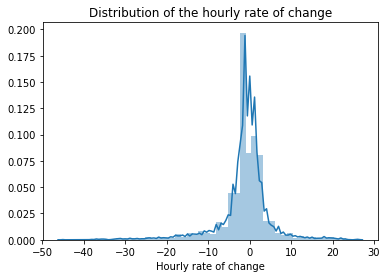

In [0]:
ax = sns.distplot(counts_union.rate_of_change)

ax.set_xlabel('Hourly rate of change')
ax.set_title('Distribution of the hourly rate of change')

The variable seems to follow a normal-like distribution with a mean close to zero, however, the values to the left are up to two times the capacity of the station. These are critical hours that must be evaluated. Now let's see the behavior of the rate of change for all days of the week.

Text(0, 0.5, 'Mean hourly rate of change')

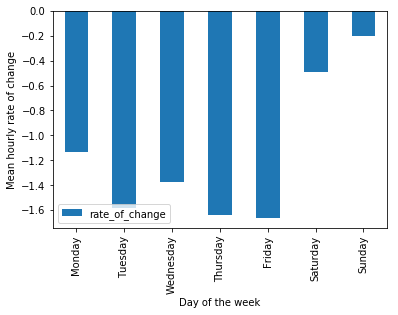

In [0]:
ax = counts_union.groupby('weekday').aggregate({'rate_of_change': 'mean'}).plot(kind='bar')

ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel('Day of the week')
ax.set_ylabel('Mean hourly rate of change')

Here we can see that for this specific station everyday we have a bike surplus every day of the week, however, for weekends this surplus is almost negligible and the suply/demand is almost balanced. Now lets get more granual, by looking at hourly averages:

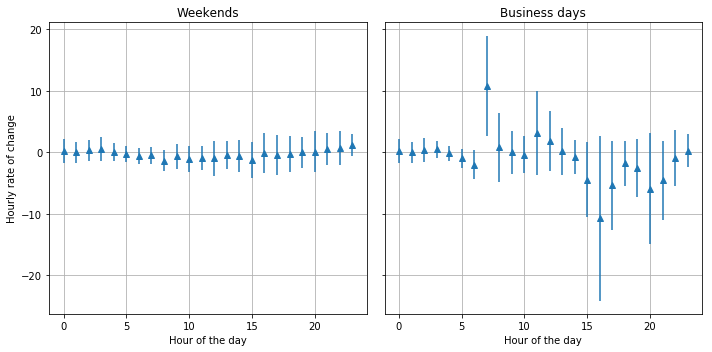

In [0]:
fig, axarr = plt.subplots(nrows = 1, ncols=2, figsize=(10,5), sharey=True)

df1 = counts_union[counts_union.weekday.isin([6,7])].groupby('hour').aggregate({'rate_of_change': ['mean', 'std']})
df2 = counts_union[~counts_union.weekday.isin([6,7])].groupby('hour').aggregate({'rate_of_change': ['mean', 'std']})

plt.sca(axarr[0])
plt.errorbar(df1.index, df1.rate_of_change['mean'], df1.rate_of_change['std'], 
             linestyle='None', marker='^')

axarr[0].set_title('Weekends')
axarr[0].set_xlabel('Hour of the day')
axarr[0].set_ylabel('Hourly rate of change')
plt.grid()

plt.sca(axarr[1])
plt.errorbar(df2.index, df2.rate_of_change['mean'], df2.rate_of_change['std'], 
             linestyle='None', marker='^')
axarr[1].set_title('Business days')
axarr[1].set_xlabel('Hour of the day')
plt.grid()
plt.tight_layout()


Here, we can extract a few insights:

* **During weekends we see a steady rate of change around zero**, this insight is important because it will mean that on average, we will not need people replenishing or taking bikes out of Union Station (here we could have some savings in resources).

* During the morning we tend to have a positive rate of change on average, and until 6 AM we have a balanced rate of change, also, we notice that for a peak demand at 7 AM the capacity of the station will satisfy the demand of about 10 bikes on average, hence the capacity is optimal for inflow of bikes during morning hours and we might not need to replenish bikes at Union Station.

* During afternoon we have the opposite, with **negative rates of change from 3 PM until 10 PM**. We will need to remove a significant amount of bikes during afternoon hours, even more during peak inflow hours (from 2 to 6) the capacity of the station will be exceeded users might arrive without anywhere to park their bikes, this might lead users to incur in overage affecting the service and even the probability of churn.

* One significant insight is the fact that on average, the mean and standard deviations will be within the capacity of the station, which seems to be optimal for the rate of change in general.


**Extreme values**

Let's dig deeper into where are these ouliers happenning. We are going to highlight the hours in which the rate of change is grater than the capacity of the station, given the fact that these peaks will create significant operational challenges.

In [0]:
#Extract those from the dataset
peaks = counts_union[(counts_union.rate_of_change > 26) | (counts_union.rate_of_change < -26)]

In [0]:
# Count those hours
peaks.shape[0]

65

Text(0.5, 0, 'Rate of change')

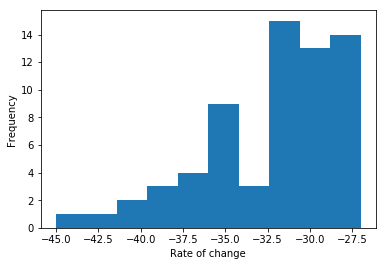

In [0]:
# How are distributed
peaks.rate_of_change.plot(kind='hist')
plt.xlabel('Rate of change')

So we have 65 hours in which we will have inflow of bikes (negative rate of change), let's check at how these are distributed throughout the hours of the day, days of the week and days of the year.

Text(0.5, 1.0, 'Count of peaks')

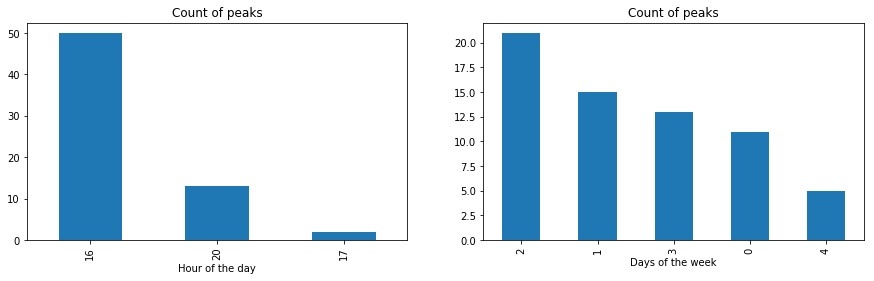

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

#Check distribution during the hours of the day
peaks.hour.value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_xlabel('Hour of the day')
ax[0].set_title('Count of peaks')

#Check distribution during the week
peaks.weekday.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Days of the week')
ax[1].set_title('Count of peaks')

In [0]:
#Check distribution during the year
peaks.dayofyear.value_counts().describe()

count    64.000000
mean      1.015625
std       0.125000
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: dayofyear, dtype: float64

Some observations regarding this graphs:

* We see that these peaks are mostly at 4 PM (busy hour for commuting), which is consistent with the data previously reviewed. At this time of the day, a large number of bikes are taken to this station for the "ride back home". However, it's interesting that the "ride to work" is not symmetric to this number. This station is used for getting home from work but not as much for getting to work.
* Almost every day of the week at 4 PM we will have an overflow of bikes at this station, however, at 5 PM and 8 PM is quite rare.
* Wednesday is the day that presents the most peaks for rate of change, followed in simmilar proportion by Tuesday, Thursday and Monday. On a Friday is rare to have a bike overflow.
* Also, we have a mean of one peak a day for this station, this insight could optimize the trips taken to Union Station to pick up bikes.

## Feature engineering for time variables

Now that we have our time variables as we wanted and the trip counts for each one of those time periods, we need to make sure that our cyclical variables, namely dayofyear, weekday and hour, will preserve the cyclical characteristics of months, days and weeks, this is to say that the first day of the week is close to the last day of the following week. [LINK](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html)

This transformation is explained in the following picture:

![alt text](http://blog.davidkaleko.com/images/unit_circle.png)


In [0]:
# Transform the three time variables into cyclical variables using sine and cosine

counts_union['dayofyear_sin'] = np.sin(counts_union.dayofyear*(2.*np.pi/365))
counts_union['dayofyear_cos'] = np.cos(counts_union.dayofyear*(2.*np.pi/365))
counts_union['weekday_sin'] = np.sin(counts_union.weekday*(2.*np.pi/7))
counts_union['weekday_cos'] = np.cos(counts_union.weekday*(2.*np.pi/7))
counts_union['hour_sin'] = np.sin(counts_union.hour*(2.*np.pi/24))
counts_union['hour_cos'] = np.cos(counts_union.hour*(2.*np.pi/24))

#Preview
counts_union.head()

,dayofyear,weekday,hour,count_trips_orig,count_trips_dest,rate_of_change,dayofyear_sin,dayofyear_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
0,0,6,0,0.0,2.0,-2.0,0.0,1.0,-0.781831,0.62349,0.000000,1.000000
1,0,6,1,1.0,0.0,1.0,0.0,1.0,-0.781831,0.62349,0.258819,0.965926
2,0,6,2,2.0,0.0,2.0,0.0,1.0,-0.781831,0.62349,0.500000,0.866025
3,0,6,3,1.0,0.0,1.0,0.0,1.0,-0.781831,0.62349,0.707107,0.707107
4,0,6,4,0.0,1.0,-1.0,0.0,1.0,-0.781831,0.62349,0.866025,0.500000


Here we can evidence that by virtue of sines and cosines, hours will be arranged in a cyclical manner so the model can obtain this information in order to process data correctly.

## Modeling using Random Forest

Now let's use our previous dataset `counts_union` to model the rate of change in Union Station using a non-linear regression model, for this case and as a first approach we will be using Random Forest to model the regression, however, further modeling iterations must be carried out.

In [0]:
#Sneak peak
counts_union.head(2)

,dayofyear,weekday,hour,count_trips_orig,count_trips_dest,rate_of_change,dayofyear_sin,dayofyear_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
0,0,6,0,0.0,2.0,-2.0,0.0,1.0,-0.781831,0.62349,0.000000,1.000000
1,0,6,1,1.0,0.0,1.0,0.0,1.0,-0.781831,0.62349,0.258819,0.965926


Now let's subset our dataset for modeling by including only the variables we need. For this case our model will be only time-dependent as since it's modeled as a cyclical process, we expect that this data could account for seasonal variables such as the temperature and precipitation.

Nevertheless, future stages of development could include other predictors such as ``is_holiday``, `mean_temperature`, `humidity`, `mean_windspeed`, `casual_rides`, `member_rides`, ``is_event_date``, among many others.

In [0]:
# Set the variables
X = counts_union[['dayofyear_sin', 'dayofyear_cos', 'weekday_sin', 'weekday_cos','hour_sin', 'hour_cos']]
y= counts_union[['rate_of_change']]

Split the dataset into training and test set for Cross validation and hyper parameters optimization

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

Now we will use ``GridSearchCV`` for evaluating a combination of hyperparameters that were previously explored. This GridSearch is already focused on a specific area of the hyperspace of parameters that was detected manually by exploring the training and cross validation $R^{2}$ one by one. These sets of parameters given should provide one optimal model derived from this data. 

In [0]:
#Create pipeline
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('rf', RandomForestRegressor(random_state=100, max_features=4))])

#Create params grid
params_list = [{'rf__n_estimators': np.linspace(30, 70, 5, endpoint=True, dtype=int),
                'rf__max_depth' : np.linspace(1, 10, 5, endpoint=True, dtype=int),
                'rf__min_samples_split': np.linspace(0.0001, 0.001, 5, endpoint=True),
                'rf__min_samples_leaf': np.linspace(1, 10, 4, endpoint=True, dtype=int),
               }]

# Perform grid search
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=params_list, 
                           cv=5, 
                           scoring='r2',
                          verbose=2,
                          n_jobs=-1,
                          return_train_score=True)
  
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 1251 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2497 out of 2500 | elapsed:  5.2min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  5.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rf',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=4,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                          

First let's get the subset of optimal parameters obtained by the ``GridSearchCV`` algorithm and its score.

In [0]:
#Get best params
grid_search.best_params_

{'rf__max_depth': 10,
 'rf__min_samples_leaf': 7,
 'rf__min_samples_split': 0.0001,
 'rf__n_estimators': 70}

In [0]:
#Get best score
grid_search.best_score_.round(2)

0.69

For this case we have chosen $R^{2}$ as the metric for model selection (as seen before). Hence, we will evaluate the results obtained with this metric for both training and test set.

In [0]:
#Use the best model for prediction on training set and get metric
r2_score(y_train, grid_search.predict(X_train)).round(2)

0.77

In [0]:
#Use the best model for prediction on test set and get metric
r2_score(y_test, grid_search.predict(X_test)).round(2)

0.7

In [0]:
# Feature importance for time series data
pd.DataFrame(data=grid_search.best_estimator_.named_steps['rf'].feature_importances_,
            index=X_train.columns)

,0
dayofyear_sin,0.241934
dayofyear_cos,0.077818
weekday_sin,0.136558
weekday_cos,0.011994
hour_sin,0.299072
hour_cos,0.232625


After reviewing the results, we can evidence that indeed modeling rate of change dependent of time as a cyclic variable helps us predict with certain accuracy its behavior.

Nevertheless, we must consider de following for **future work**

* Even with the data at hand, the model could be improved applying a more rigorous hyperparameter optimization, which is key in stochastic algorithms. Or another alternative could be to model the demand as time series using models such as ARIMA or SARIMA and compare its performance.

* To improve model metrics, we could also think of adding data from previous and following years to the model, specifically to provide more yearly seasonality information to the model, this might reduce variance.

* The model is in early stages of development, to reduce model variance (overfitting) there are some solutions to be tested: restrict complexity using hyperparameters (although this was carried out) and get more data to improve generalization capability.

* Using the real-time station status data available through the API, one could instantly assess model performance using real data.


### Evaluating predictions for months of high demand

We will compare the predictions for June, July and August into a timeline with the real data to review overall model performance.

In [0]:
#Set the time range
init_day = 152  #Jun 1st
final_day = 243  #Aug 31st

#Real data
real_y = y.rate_of_change[(counts_union.dayofyear >= init_day) & 
                       (counts_union.dayofyear <= final_day)]

#Calculate predictions
X_subset = X[(counts_union.dayofyear >= init_day) & 
                       (counts_union.dayofyear <= final_day)]

predic_y = grid_search.predict(X_subset)

<function matplotlib.pyplot.show>

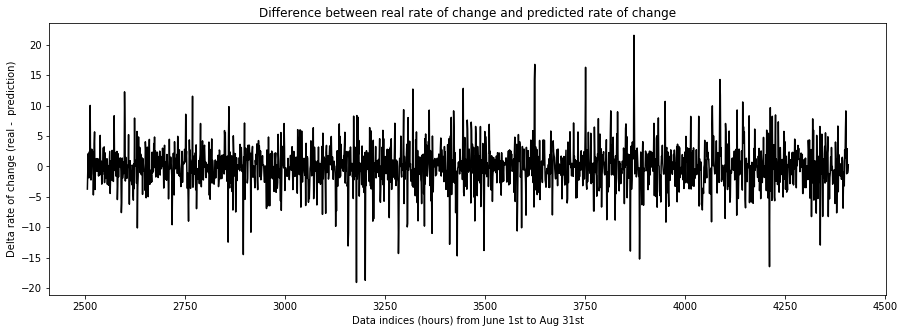

In [0]:
#Get the indices of the data points
x_values = counts_union.index[(counts_union.dayofyear >= init_day) & (counts_union.dayofyear <= final_day)]

#Plot
fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(15,5))

#Plot difference between real and predicted value
plt.plot(x_values, real_y- predic_y, c='black')
plt.xlabel('Data indices (hours) from June 1st to Aug 31st')
plt.ylabel('Delta rate of change (real -  prediction)')
plt.title('Difference between real rate of change and predicted rate of change')
plt.show

### Final remarks

* The most important factor for prediction is the hour of the day, both on the cosine and sine components. The dayofyear and weekday also have some influence, mainly on their sine component, since these are the variables that provide information about weekly and yearly seasonality.

* In terms of prediction for months of high demand, the model seems to do a good job on most days, in which the difference between the real value and prediction are close to zero and between the $[-5,5]$ range, with a capacity of 26 bikes, this error might be acceptable (depending on the hour of the day). However, several peak points in the difference are still present, it's important identify explanatory variables for those peaks in order to improve model performance.

* This model could be used for predicting the performance of other stations aswell since the data is already clean and prepared for the analysis.
